In [1]:
####################################################
#
# T E S T   D A T A   G E N E R A T I O N
#
# this code is not part of mendonca algorithm
# and used only for experiment purpose in
# order to generate cameras and points
# 
####################################################

In [59]:
import numpy as np
import cv2
import scipy.optimize as opt
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

np.set_printoptions(suppress=True)

In [60]:
rng = np.random.default_rng(3122787423)

In [61]:
def plot_3d(x,y,z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z)
    plt.show()

In [62]:
def p3t(T,x,y,z):
    # apply a Projective 3D Transform
    xyz = np.concatenate((x, y, z),axis=1)
    column_ones = np.ones((len(x),1))
    tmp = T @ (np.concatenate((xyz,column_ones),axis=1)).T
    xp = (tmp[0,:]/tmp[3,:]).T
    yp = (tmp[1,:]/tmp[3,:]).T
    zp = (tmp[2,:]/tmp[3,:]).T
    return xp,yp,zp

In [63]:
def projf(P,x,y,z):
# PROJ  compute perspective projection (from 3D to pixel coordinates)
# pixel positions are returned with floating point precision
    c3d = np.concatenate((x, y, z),axis=1)
    column_ones = np.ones((len(x),1))
    h3d = (np.concatenate((c3d,column_ones),axis=1)).T
    h2d = P @ h3d

    c2d = h2d/ h2d[2,:]

    u = c2d[0,:].T
    v = c2d[1,:].T
    return u,v

In [64]:
def plot_2d(points):  
    # input: matrix that consists array of points (x,y) per image
    num_of_images =  points.shape[2]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, num_of_images))
    for image in range(num_of_images):
        x = points[:,0,image]
        y = points[:,1,image]
        plt.scatter(x, y, color=colors[image])
    plt.show()

In [65]:
def plot_2d_separate(points):
    # input: matrix that consists array of points (x,y) per image
    num_of_images = points.shape[2]
    plot_columns = int(round(math.sqrt(num_of_images)))
    plot_rows = int(round(math.sqrt(num_of_images)))+1
    fig, axes = plt.subplots(plot_columns,plot_rows, figsize=(20, 20))
    for i, ax in enumerate(axes.ravel()):
        if(i < num_of_images):
            x = points[:,0,i]
            y = points[:,1,i]
            ax.set_title("View {}".format(i))
            ax.scatter(x, y)
    plt.show()

In [66]:
def conver_to_col(x):
    return np.reshape(x,(len(x),1))

In [67]:
def rcam(A):
# RCAM generate a random camera
#    generate a random camera pointing to lookp, positioned at an average 
#    distance ad form the origin, with a std dev of sd 
#    A is the intrinsic parameters matrix

    ad=2.5
    sd=0.25
    lookp=np.zeros((1,3))
    eyep = rng.uniform(-1,1,size=(1,3))-0.5
    R = np.zeros((3,3))
    eyep = eyep/np.linalg.norm(eyep) * (ad + sd*rng.random(1))

    R[2,:] = lookp - eyep/np.linalg.norm(lookp - eyep)
    R[1,:] = np.cross(R[2,:],rng.uniform(size=(1,3)))
    R[1,:] = R[1,:]/np.linalg.norm(R[1,:])
    R[0,:] = np.cross(R[1,:],R[2,:])
    Rt = np.concatenate((R,-R @ eyep.T),axis=1)

    return A @ Rt


In [68]:
numberOfViews = 5
numberOfPoints = 50
imagePoints = np.zeros((numberOfPoints,2,numberOfViews))
PPM = np.zeros((3,4,numberOfViews))
PPMGT = np.zeros((3,4,numberOfViews))

In [69]:
def create_fake_points():
    data = (rng.uniform(size=(numberOfPoints,3),)-0.5)/(math.sqrt(3)/2)
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    return x, y, z

In [70]:
true_K = np.array([
    [800,0,256],
    [0,800,256],
    [0,0,1]
    ])
x, y, z = create_fake_points()
A = true_K
P = rcam(A)
invAP = np.linalg.inv(A) @ P
lower_line = [[0,0,0,1]]
G0 = np.concatenate((invAP, lower_line),axis=0)

In [71]:
x,y,z = p3t(
    G0,
    conver_to_col(x),
    conver_to_col(y),
    conver_to_col(z)
)
P = A @ np.concatenate((np.identity(3), np.zeros((3,1))),axis=1)

u,v = projf(P,conver_to_col(x),conver_to_col(y),conver_to_col(z))

imagePoints[:,0,0] = u
imagePoints[:,1,0] = v
PPMGT[:,:,0] = P

In [72]:
for view in range (1,numberOfViews):
    # random camera position
    P = rcam(A)
    # apply world coordinate transformation
    P = P @ np.linalg.inv(G0);
    # project world points to image points
    u,v = projf(P,conver_to_col(x),conver_to_col(y),conver_to_col(z))
    imagePoints[:,0,view] = u
    imagePoints[:,1,view] = v
    PPMGT[:,:,view] = P   

# A Simple Technique for Self-Calibration
Alexander Kruglyak

Sofya Zybtsovsky

### Introduction
The goal of Computer Vision is to compute properties (mainly geometric) of the three-dimensional world from images.
One of the challenging problems of Computer Vision is to reconstruct a 3D model of a scene from a moving camera.
<br>Possible applications include: navigation of autonomous vehicles, objects recognition, reverse engineering and synthesis of virtual environments.


In general, assumption that the intrinsic parameters of the camera (focal length, image center and aspect ratio) are known. <br>
Computing camera motion in this case is a well known problem in photogrammetry, called relative orientation, for which several methods are available.<br>Given all the parameters of the camera, reconstruction is straightforward.


### Projection

We want a mathematical model to describe how 3D World points get projected into 2D Pixel coordinates.

### Forward projection


<center><img src="images/forward_projection.png"></center>

### Backward projection

<center><img src="images/backward_projection.png"></center>

## Mathematical model

<center><img src="images/ProjectionMatrix.jpg"></center>

## Self-calibration
Self-calibration is the process of finding intrinsic parameters of the camera without any actual calibration object:
- focal length
- image center (principal point)
- aspect ratio (pixel skew)

### Intrinsic matrix K
5 degrees of freedom: 2 for focal length, 2 for offset, and 1 for skewness

<center><img src="images/K_matrix.png"></center>

## Approaches to find calibration matrix

### Hartley algorithm
- non-iterative algorithm 
- finds only focal lengths 
- requires at least 8 conjugate pairs points
- “heavy” mathematics calculation (SVD, determinants equation, and many equation, and more...)


### Hartley algorithm - disadvantages
- determining only the focal lengths 
- requires all other internal camera parameters to be known
- heavy computations


### Mendonca - algorithm
- extension of Hartley’s self-calibration technique
- Input: at least 24 points (3+ images such as each contains 8+ correspondence points)
- Output: <b>all</b> intrinsic parameters

### Mendonca - algorithm
Based on the theorem of essential matrix E=[t]<sub>x</sub>R:

A real matrix E<sub>3x3</sub> can be factorized as product of a nonzero skew-symmetric matrix <b>t</b> (translation) and a rotation matrix <b>R</b> 
<br><b>if and only if</b>
<br>E has 2 identical singular values and a zero singular value
<br><br>E<sub>3x3</sub> =[t]<sub>x</sub>R   <=>    <sup>1</sup>𝞼=<sup>2</sup>𝞼, <sup>3</sup>𝞼=0

### Mendonca - algorithm
<br><br>algo aims to find 2 singular values (other than zero) 
that are as close as possible:
<br><br><sup>1</sup>𝞼 - <sup>2</sup>𝞼 -> 0
<br><br>K found by algo -> true intrinsic matrix

### Mendonca algorithm
Input: at least 24 points (3+ images such as each contains 8+ correspondence points)

Output:  K (intrinsic  parameters)

1. Init some random matrix K
2. Calculate fundamental matrix <b>F</b> for each pair of images
3. Calculate essential matrix <b>E</b> for each pair of images (based on F and K)
4. Decompose E and find singular values (SVD)
4. Calculate error (cost function)
6. Minimize error
7. Then cost function reach global minimum: return K


### Input
50 points with 5 different views

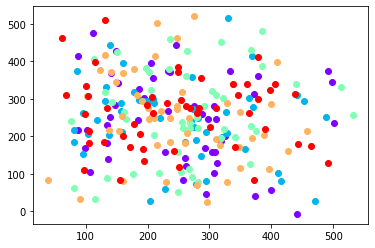

In [73]:
plot_2d(imagePoints)

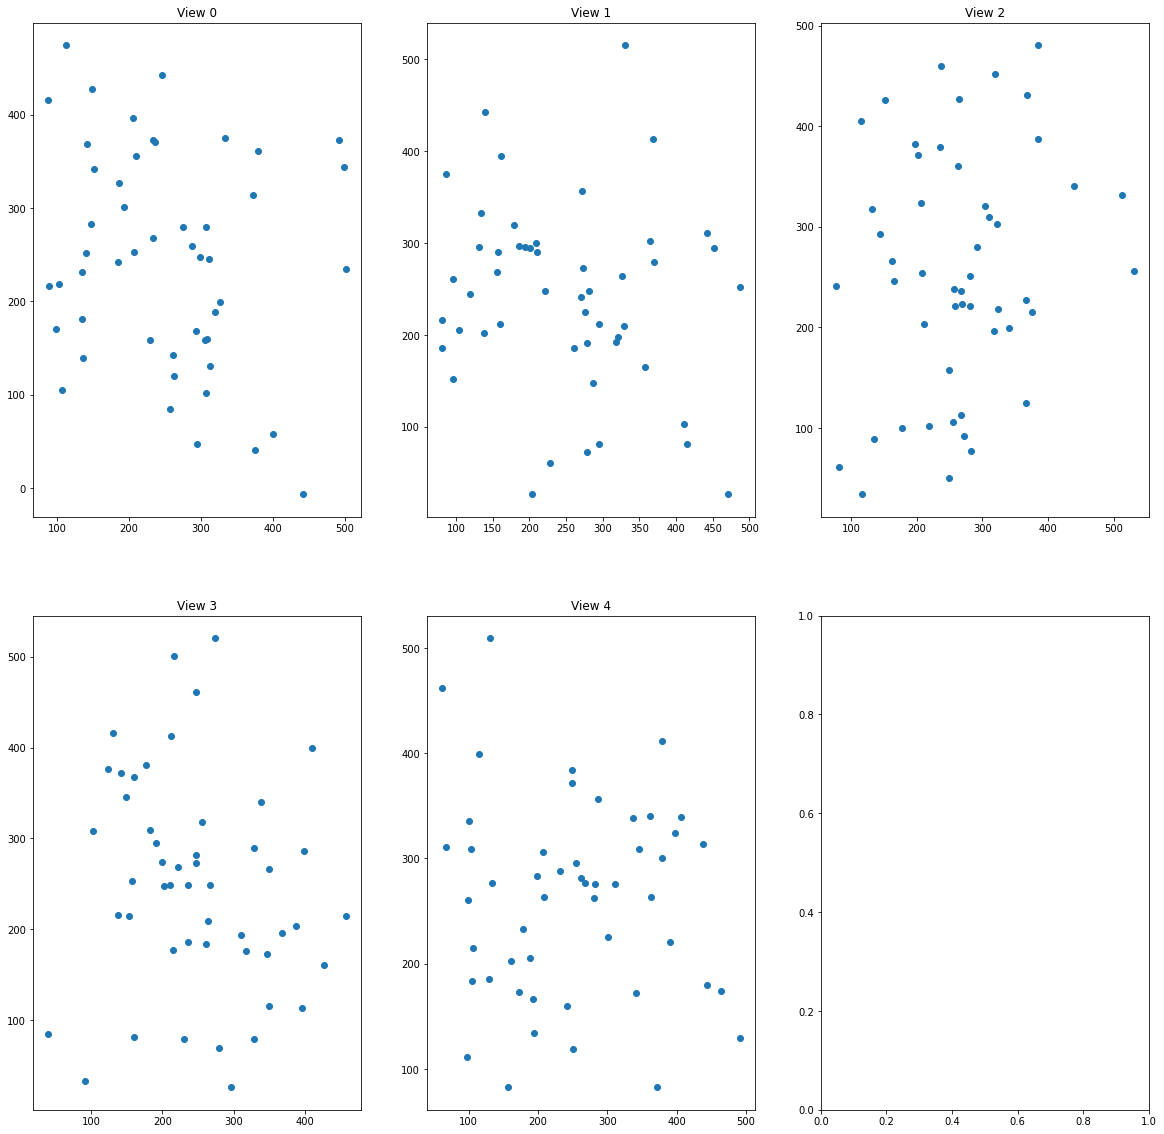

In [74]:
plot_2d_separate(imagePoints)

In [75]:
print(imagePoints.shape)
print(imagePoints)

(50, 2, 5)
[[[111.58224779 139.94549073  80.46274641 274.34902127 491.80624926]
  [474.61022454 442.65165232  61.57051883 520.2840845  129.61968581]]

 [[209.54990699 186.26336769 254.2524521  160.08288915 378.5136024 ]
  [355.99710595 297.14220299 105.75998736 367.92443132 300.51917454]]

 [[287.75704535 281.11491012 280.3518727  236.07782925 261.56041257]
  [259.24200232 247.84715214 250.73641143 249.40417916 281.65801376]]

 [[304.6977166  328.96766477 262.37474022 317.767928   178.28824517]
  [158.89154361 210.32222461 360.88292674 176.50584419 232.96023085]]

 [[184.41724716 159.36871244 281.10277838 201.75436278 231.27703581]
  [242.47974538 212.35143843 221.6226932  247.6416408  287.73441065]]

 [[134.7273839  103.47025089 257.46291648 210.98335273 208.09316358]
  [231.74521555 205.15805707 221.25998791 248.48586513 263.00342721]]

 [[491.87041931 441.66340831 317.86741599 191.37983721 361.12395243]
  [373.16580271 310.735454   196.5274842  295.49179515 340.32089719]]

 [[233.47

### 1. Init some random matrix K

In [78]:
initial_K = [100,0,100,200]
print(np.array([[initial_K[0],0,initial_K[1]],[0,initial_K[2],initial_K[3]],[0,0,1]]))

[[100   0   0]
 [  0 100 200]
 [  0   0   1]]


### 2. Calculate fundamental matrix F for each pair of images (for example via 8-point algorithm with data normalization)


In [79]:
def calc_fund_matrix(points1,points2):
    '''
    Takes in 2 arrays of matching points 
    Return Fundamental matrix 
    '''
    F, mask = cv2.findFundamentalMat(points1,points2)

    return F 

Fs = np.zeros((3,3,numberOfViews,numberOfViews))

for i in range(numberOfViews):
    for j in range(i+1,numberOfViews):
        Fs[:,:,i,j] = calc_fund_matrix(imagePoints[:,:,i],imagePoints[:,:,j])

### 3. Calculate essential matrix E for each pair of images (based on F and K)

In [80]:
def calculate_essential_matrix(K,F):
    return K.T @ F @ K

### 4. Decompose E and find singular values (SVD)

In [81]:
def decompose_singular_values(E):
    _,D,_ = np.linalg.svd(E)
    # Singular Values (3rd value, D[3] is 0 according to theorem)
    r = D[0]
    s = D[1]
    return r, s

### 5. Calculate error (cost function)

<sup>1</sup>𝞼<sub>ij</sub> , <sup>2</sup>𝞼<sub>ij</sub>  - non zero singular values of E<sub>ij</sub> = K<sup>T</sup><sub>i</sub>F<sub>ij</sub>K<sub>j</sub>, such as <sup>1</sup>𝞼<sub>ij</sub> > <sup>2</sup>𝞼<sub>ij</sub>

w<sub>ij</sub> - normalized weight factors

Minimize cost function:
<center><img src="images/cost_function.png"></center>

In [82]:
def mendonca_cost_func(X):
    '''
    computes Mendonca & Cipolla Cost function to find the Optimal Intrinsic Parameters
    Input
    X      - Approximate Values of Intrinsics - 1D array with length 5
    Output
    cost    - Computed Cost
    '''

    K = np.array([
        [X[0],0,X[1]],
        [0,X[2],X[3]],
        [0,0,1]
    ])
    cost = 0
    nof_images = numberOfViews
    Den = nof_images*(nof_images-1)/2 

    for i in range(0,nof_images-1):
        for j in range (i+1,nof_images):
            E = calculate_essential_matrix(K, Fs[:,:,i,j])
            r,s = decompose_singular_values(E)
            cost+= (1/Den) * (r - s)/s

    return cost

### 6. Minimize error (e.g, via least squares)

In [83]:
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')

### 7. Then cost function reach global minimum: return K

In [87]:
result_K = np.array([
    [ res.x[0], 0 ,       res.x[1] ],
    [ 0,        res.x[2], res.x[3] ],
    [ 0,        0,        1        ]
])
print ("Result K\n",np.matrix(result_K))
print("True K\n",true_K)

Result K
 [[799.98946037   0.         255.99919228]
 [  0.         799.98861106 255.99955088]
 [  0.           0.           1.        ]]
True K
 [[800   0 256]
 [  0 800 256]
 [  0   0   1]]


### Mendonca | Advantages

- simple mathematical calculation

- find all unknown intrinsic camera parameters

- always converges to the global minimum

- has no bias towards any particular image of the sequence

- insensitive to the initialization


In [86]:
initial_K = [250,50,100,150]
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],0,res.x[1]],[0,res.x[2],res.x[3]],[0,0,1]])
print (np.matrix(result_K))

[[799.98946037   0.         255.99919228]
 [  0.         799.98861106 255.99955088]
 [  0.           0.           1.        ]]


Mendonca, Paulo RS & Roberto Cipolla "A simple technique for self-calibration" 1999,  University of Cambridge, UK